In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

In [2]:
# FUNCTIONS
def stdize_columns(df):
    return df.columns.str.lower().str.replace(' ', '_')

def show_corr_heatmap(df, figsize, export_path='figs/corr_heatmap.png'):
    """Show andeExport half correlation matrix for the dataset in a .png figure 
    print couples with highest correlation and let user decide if remove one of them from
    dataset. In that case, returns a new copy of the DataFrame"""
    mask = np.zeros_like(df.corr()) # Matrix full of zeros with shape of df.corr()
    mask[np.triu_indices_from(mask)] = True # upper tridiagonal mask
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df.corr(), mask=mask, annot=True)
    if not os.path.isdir(export_path.split('/')[0]):
        os.makedirs(export_path.split('/')[0])
    plt.savefig(export_path, dpi=600)

def remove_outliers(df, skip_columns, threshold=1.5):
    initial_rows = df.shape[0]
    for col in df.select_dtypes(np.number).columns:
        if col not in skip_columns:
            upper = np.percentile(df[col], 75)  
            lower = np.percentile(df[col], 25)  
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            df = df[(df[col]>lower_limit) & (df[col]<upper_limit)]
            assert not df.empty, 'Threshold too high for col: ' + col
        
    print(f'Loss of \
        {round((initial_rows - df.shape[0])/ initial_rows*100, 1)}%\
        of initial data')
    return df

def scale_data(sets, scaler):
    """Applies a scaler class to test and train set"""
    scaled_sets = []
    for set in sets:
        set_scaled = scaler().fit_transform(set.select_dtypes(np.number))
        set[set.select_dtypes(np.number).columns] = set_scaled
        scaled_sets.append(set)
    return scaled_sets


def encode_data(scaled_sets, encoder, cols_to_encode):
    scaled_and_encoded_sets = []
    try:
        for scaled_set in scaled_sets:
            enc = encoder(drop='first').fit(scaled_set[cols_to_encode])
            oh_encoded_scaled_set = pd.DataFrame(enc.transform(scaled_set[cols_to_encode]).toarray())
            oh_encoded_scaled_set= oh_encoded_scaled_set.set_index(scaled_set.index)
            scaled_and_encoded_set = scaled_set.drop(scaled_set[cols_to_encode], axis=1).join(oh_encoded_scaled_set)
            scaled_and_encoded_sets.append(scaled_and_encoded_set)
    except:
        raise
    finally:
        return scaled_and_encoded_sets



In [3]:
DF_URL = "./files_for_lab/csv_files/marketing_customer_analysis.csv"
df = pd.read_csv(DF_URL)

In [4]:
df.head(3).transpose()

,0,1,2
Customer,BU79786,QZ44356,AI49188
State,Washington,Arizona,Nevada
Customer Lifetime Value,2763.519279,6979.535903,12887.43165
Response,No,No,No
Coverage,Basic,Extended,Premium
Education,Bachelor,Bachelor,Bachelor
Effective To Date,2/24/11,1/31/11,2/19/11
EmploymentStatus,Employed,Unemployed,Employed
Gender,F,F,F
Income,56274,0,48767


In [5]:
df.columns = stdize_columns(df)
df.columns


Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

In [6]:
df.set_index('customer', inplace=True)

In [7]:
df.describe().apply(lambda x: round(x,1)).transpose()

,count,mean,std,min,25%,50%,75%,max
customer_lifetime_value,9134.0,8004.9,6871.0,1898.0,3994.3,5780.2,8962.2,83325.4
income,9134.0,37657.4,30379.9,0.0,0.0,33889.5,62320.0,99981.0
monthly_premium_auto,9134.0,93.2,34.4,61.0,68.0,83.0,109.0,298.0
months_since_last_claim,9134.0,15.1,10.1,0.0,6.0,14.0,23.0,35.0
months_since_policy_inception,9134.0,48.1,27.9,0.0,24.0,48.0,71.0,99.0
number_of_open_complaints,9134.0,0.4,0.9,0.0,0.0,0.0,0.0,5.0
number_of_policies,9134.0,3.0,2.4,1.0,1.0,2.0,4.0,9.0
total_claim_amount,9134.0,434.1,290.5,0.1,272.3,383.9,547.5,2893.2


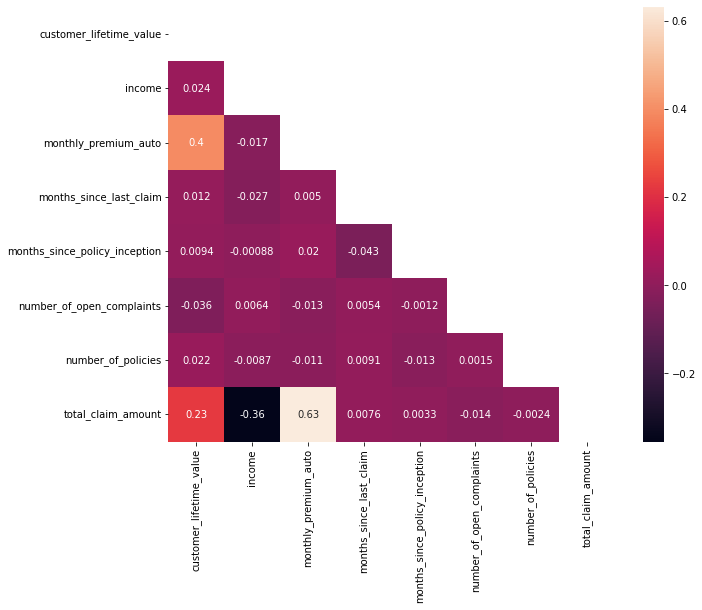

In [8]:
# Analyze Multicollinerity
show_corr_heatmap(df, (10, 8))

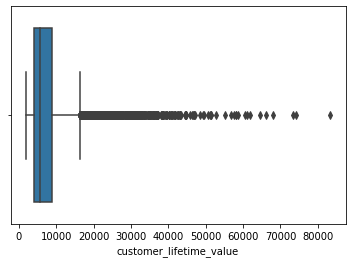

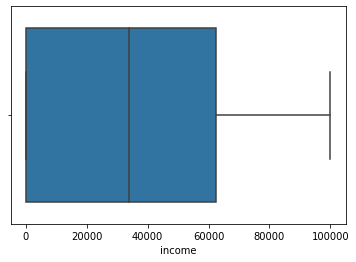

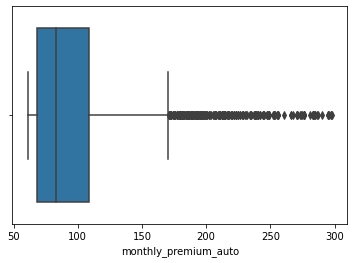

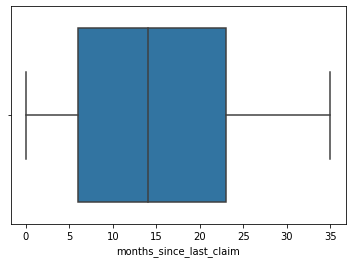

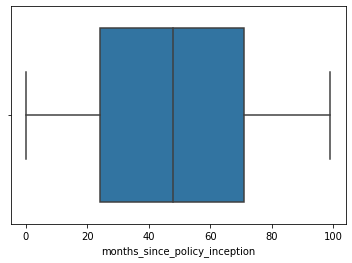

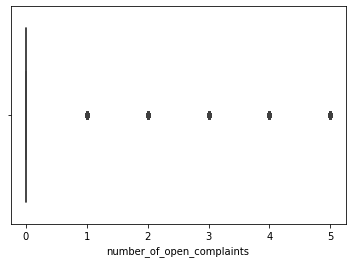

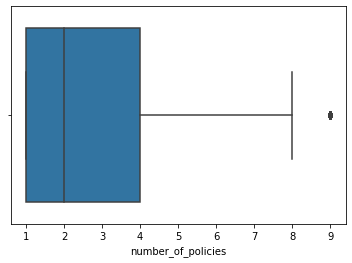

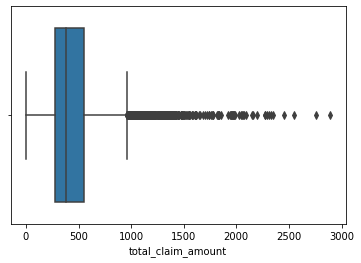

In [9]:
# outliers
for col in df.select_dtypes(np.number).columns:
    sns.boxplot(x=df[col])
    plt.show()

In [10]:
# Copying data before removing outliers
df01_copied_from_df = df.copy() 
df_without_outliers = remove_outliers(df01_copied_from_df, threshold=1.5,
                        skip_columns=['total_claim_amount', 
                                      'number_of_open_complaints'])

df_without_outliers.head().transpose()



Loss of         16.6%        of initial data


customer,BU79786,QZ44356,AI49188,WW63253,HB64268
state,Washington,Arizona,Nevada,California,Washington
customer_lifetime_value,2763.519279,6979.535903,12887.43165,7645.861827,2813.692575
response,No,No,No,No,No
coverage,Basic,Extended,Premium,Basic,Basic
education,Bachelor,Bachelor,Bachelor,Bachelor,Bachelor
effective_to_date,2/24/11,1/31/11,2/19/11,1/20/11,2/3/11
employmentstatus,Employed,Unemployed,Employed,Unemployed,Employed
gender,F,F,F,M,M
income,56274,0,48767,0,43836
location_code,Suburban,Suburban,Suburban,Suburban,Rural


In [11]:
X = df_without_outliers.drop(['total_claim_amount'], axis=1)
y = df_without_outliers['total_claim_amount']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
X_train_scaled, X_test_scaled = scale_data(sets=[X_train, X_test], scaler=MinMaxScaler)

In [14]:
# Categorial
for col in X_train.select_dtypes(np.object).columns:
    print(col+':',
          X_train[col].unique(),
          'Unique count: '+str(len(X_train[col].unique())),
           sep='\n', end='\n\n')

state:
['Arizona' 'California' 'Oregon' 'Washington' 'Nevada']
Unique count: 5

response:
['No' 'Yes']
Unique count: 2

coverage:
['Basic' 'Premium' 'Extended']
Unique count: 3

education:
['College' 'Bachelor' 'Master' 'High School or Below' 'Doctor']
Unique count: 5

effective_to_date:
['2/13/11' '2/11/11' '2/26/11' '1/11/11' '2/19/11' '1/27/11' '2/9/11'
 '1/1/11' '2/17/11' '1/10/11' '1/9/11' '2/20/11' '2/24/11' '1/7/11'
 '1/6/11' '2/3/11' '1/31/11' '1/28/11' '2/4/11' '2/18/11' '2/6/11'
 '1/14/11' '2/16/11' '2/22/11' '2/21/11' '1/24/11' '2/5/11' '1/23/11'
 '1/2/11' '1/26/11' '1/19/11' '1/30/11' '1/25/11' '1/13/11' '1/29/11'
 '1/8/11' '2/1/11' '2/14/11' '2/10/11' '1/3/11' '1/20/11' '2/28/11'
 '1/16/11' '2/2/11' '2/15/11' '2/25/11' '1/15/11' '1/22/11' '2/27/11'
 '1/21/11' '2/23/11' '1/12/11' '1/17/11' '1/5/11' '1/18/11' '2/7/11'
 '2/12/11' '2/8/11' '1/4/11']
Unique count: 59

employmentstatus:
['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Unique count: 5

gender:
['F' 

In [17]:
X_train_scaled_cols_to_encode = list(X_train_scaled.select_dtypes(np.object).columns)

X_train_scaled_and_encoded, X_test_scaled_and_encoded = encode_data(
    scaled_sets=[X_train_scaled, X_test_scaled], encoder=OneHotEncoder, cols_to_encode=X_train_scaled_cols_to_encode
    )

display(X_train_scaled_and_encoded.shape)
display(X_test_scaled_and_encoded.shape)

(5331, 106)

(2286, 106)

In [19]:
def apply_model(X_train, X_test, y_train, model):
    model = model()
    model.fit(X_train, y_train)
    return model.predict(X_test)

predictions = apply_model(X_train_scaled_and_encoded, X_test_scaled_and_encoded, y_train, LinearRegression)


In [20]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.7449985997235591, 84.39422353065312, 115.68134479624568)